In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/sample_submission.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv
/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv


# Basic Info & Data Types

In [2]:
train = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/train.csv")
test = pd.read_csv("/kaggle/input/mlp-term-3-2025-kaggle-assignment-2/test.csv")

train.head()

,id,adults,children,weekends,weekdays,meal_type,room_type,arrival,lead_time,segment,repeat,price,requests,booking_status
0,0,2,0,0,1,Not Selected,Room_Type 1,2018-05-21,54.0,Online,0,116.10,0,1
1,1,1,0,3,6,Not Selected,Room_Type 1,2018-11-12,12.0,Online,0,71.87,1,1
2,2,2,0,0,2,Meal Plan 1,Room_Type 2,2018-01-06,34.0,Online,0,71.55,1,0
3,3,1,0,2,1,Meal Plan 1,Room_Type 1,2018-02-14,4.0,Corporate,1,66.00,0,0
4,4,2,0,2,3,Meal Plan 1,Room_Type 1,2018-07-08,155.0,Offline,0,72.25,0,0


In [3]:
train.info()
train.describe()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29500 entries, 0 to 29499
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              29500 non-null  int64  
 1   adults          29500 non-null  int64  
 2   children        29500 non-null  int64  
 3   weekends        29500 non-null  int64  
 4   weekdays        29500 non-null  int64  
 5   meal_type       29500 non-null  object 
 6   room_type       28659 non-null  object 
 7   arrival         29500 non-null  object 
 8   lead_time       27805 non-null  float64
 9   segment         29500 non-null  object 
 10  repeat          29500 non-null  int64  
 11  price           27917 non-null  float64
 12  requests        29500 non-null  int64  
 13  booking_status  29500 non-null  int64  
dtypes: float64(2), int64(8), object(4)
memory usage: 3.2+ MB


id                   0
adults               0
children             0
weekends             0
weekdays             0
meal_type            0
room_type          841
arrival              0
lead_time         1695
segment              0
repeat               0
price             1583
requests             0
booking_status       0
dtype: int64

# Handle Missing Values

In [4]:
# Fill numerical missing values with median
num_cols = train.select_dtypes(include=['int64','float64']).columns
for col in num_cols:
    train[col].fillna(train[col].median(), inplace=True)

# Fill categorical missing values with mode
cat_cols = train.select_dtypes(include=['object']).columns
for col in cat_cols:
    train[col].fillna(train[col].mode()[0], inplace=True)

train.isnull().sum()


/tmp/ipykernel_13/788962448.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].median(), inplace=True)
/tmp/ipykernel_13/788962448.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

id                0
adults            0
children          0
weekends          0
weekdays          0
meal_type         0
room_type         0
arrival           0
lead_time         0
segment           0
repeat            0
price             0
requests          0
booking_status    0
dtype: int64

# Remove Duplicates

In [5]:
train.drop_duplicates(inplace=True)
train.shape

(29500, 14)

# Handle Outliers (IQR Method)

In [6]:
for col in num_cols:
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    train[col] = np.where(train[col] < lower, lower,
                   np.where(train[col] > upper, upper, train[col]))


# Visualizations

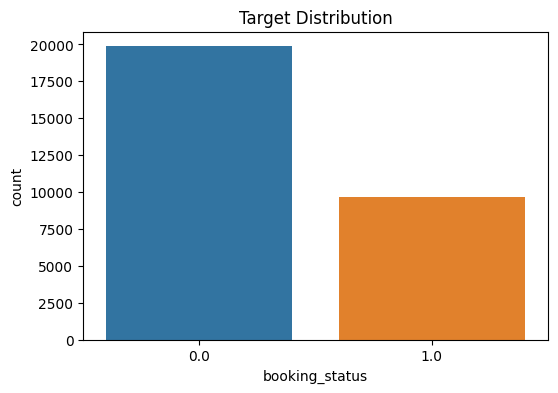

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


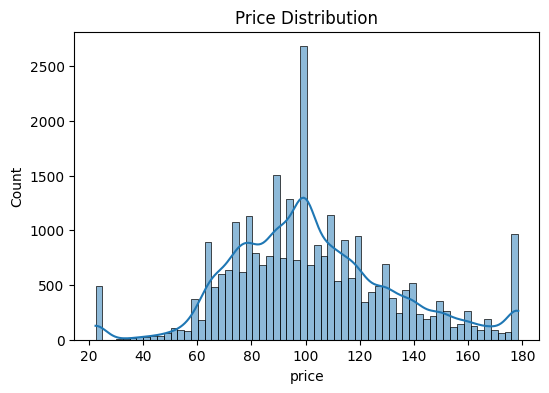

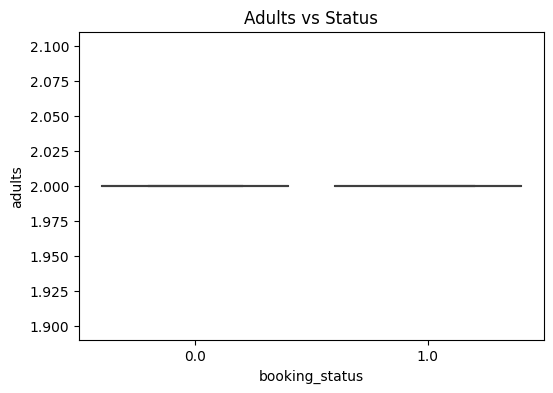

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=train['booking_status'])
plt.title("Target Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(train['price'], kde=True)
plt.title("Price Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x=train['booking_status'], y=train['adults'])
plt.title("Adults vs Status")
plt.show()


# Split Features/Target

In [8]:
X = train.drop("booking_status", axis=1)
y = train["booking_status"]

X.head()

,id,adults,children,weekends,weekdays,meal_type,room_type,arrival,lead_time,segment,repeat,price,requests
0,0.0,2.0,0.0,0.0,1.0,Not Selected,Room_Type 1,2018-05-21,54.0,Online,0.0,116.10,0.0
1,1.0,2.0,0.0,3.0,6.0,Not Selected,Room_Type 1,2018-11-12,12.0,Online,0.0,71.87,1.0
2,2.0,2.0,0.0,0.0,2.0,Meal Plan 1,Room_Type 2,2018-01-06,34.0,Online,0.0,71.55,1.0
3,3.0,2.0,0.0,2.0,1.0,Meal Plan 1,Room_Type 1,2018-02-14,4.0,Corporate,0.0,66.00,0.0
4,4.0,2.0,0.0,2.0,3.0,Meal Plan 1,Room_Type 1,2018-07-08,155.0,Offline,0.0,72.25,0.0


# Preprocessing (Scaling + Encoding)

In [9]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

numerical = X.select_dtypes(include=['int64','float64']).columns
categorical = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)


# Build 7 ML Models

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss'),
    "LightGBM": LGBMClassifier()
}

results = {}

for name, model in models.items():
    pipe = Pipeline([("prep", preprocessor), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_val)
    acc = accuracy_score(y_val, preds)
    results[name] = acc
    print(name, ":", acc)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression : 0.803728813559322
Decision Tree : 0.8440677966101695
Random Forest : 0.8793220338983051
Gradient Boosting : 0.8323728813559322
KNN : 0.8284745762711865
XGBoost : 0.8613559322033898
[LightGBM] [Info] Number of positive: 7715, number of negative: 15885
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1641
[LightGBM] [Info] Number of data points in the train set: 23600, number of used features: 439
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326907 -> initscore=-0.722209
[LightGBM] [Info] Start training from score -0.722209
LightGBM : 0.8572881355932204


# Hyperparameter Tuning

In [11]:
from sklearn.model_selection import GridSearchCV

rf_params = {
    "model__n_estimators":[100,200],
    "model__max_depth":[5,10,None]
}

rf_grid = GridSearchCV(
    Pipeline([("prep", preprocessor), ("model", RandomForestClassifier())]),
    rf_params, cv=3, scoring="accuracy"
)

rf_grid.fit(X_train, y_train)
print("Best RF Accuracy:", rf_grid.best_score_)


Best RF Accuracy: 0.8713983943997857


### XGBoost

In [12]:
xgb_params = {
    "model__max_depth":[3,5,7],
    "model__learning_rate":[0.01,0.1]
}

xgb_grid = GridSearchCV(
    Pipeline([("prep", preprocessor), ("model", XGBClassifier(eval_metric='logloss'))]),
    xgb_params, cv=3, scoring="accuracy"
)

xgb_grid.fit(X_train, y_train)
print("Best XGB Accuracy:", xgb_grid.best_score_)


Best XGB Accuracy: 0.8578813608084562


### LightGBM

# Train Best Model on Full Training Set

In [13]:
lgb_params = {
    "model__num_leaves":[31,50],
    "model__learning_rate":[0.01,0.1]
}

lgb_grid = GridSearchCV(
    Pipeline([("prep", preprocessor), ("model", LGBMClassifier())]),
    lgb_params, cv=3, scoring="accuracy"
)

lgb_grid.fit(X_train, y_train)
print("Best LGB Accuracy:", lgb_grid.best_score_)


[LightGBM] [Info] Number of positive: 5143, number of negative: 10590
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1490
[LightGBM] [Info] Number of data points in the train set: 15733, number of used features: 365
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326893 -> initscore=-0.722274
[LightGBM] [Info] Start training from score -0.722274
[LightGBM] [Info] Number of positive: 5143, number of negative: 10590
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 15733, number of used features: 367
[LightGBM] [Info] 

# Predict on Test Data

In [14]:
best_model_name = max(results, key=results.get)
print("Best Model:", best_model_name)

best_model = models[best_model_name]
final_pipe = Pipeline([("prep", preprocessor), ("model", best_model)])
final_pipe.fit(X, y)

Best Model: Random Forest


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['id', 'adults', 'children', 'weekends', 'weekdays', 'lead_time',
       'repeat', 'price', 'requests'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['meal_type', 'room_type', 'arrival', 'segment'], dtype='object'))])),
                ('model', RandomForestClassifier())])

In [15]:
# Handle missing values in test set

# Numeric columns
for col in num_cols:
    if col in test.columns:
        test[col].fillna(train[col].median(), inplace=True)

# Categorical columns
for col in cat_cols:
    if col in test.columns:
        test[col].fillna(train[col].mode()[0], inplace=True)

# Verify
test.isnull().sum()


/tmp/ipykernel_13/2356882383.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[col].fillna(train[col].median(), inplace=True)
/tmp/ipykernel_13/2356882383.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

id           0
adults       0
children     0
weekends     0
weekdays     0
meal_type    0
room_type    0
arrival      0
lead_time    0
segment      0
repeat       0
price        0
requests     0
dtype: int64

In [16]:
test_preds = final_pipe.predict(test)


# Create Submission File

In [17]:
import os

for col in num_cols:
    if col in test.columns:
        test[col].fillna(train[col].median(), inplace=True)

for col in cat_cols:
    if col in test.columns:
        test[col].fillna(train[col].mode()[0], inplace=True)

test_preds = final_pipe.predict(test)

print("Predictions generated:", len(test_preds))

id_col = None
for c in test.columns:
    if "id" in c.lower():
        id_col = c
        break

if id_col is None:
    raise ValueError("⚠️ Could not find ID column in test dataset!")

submission = pd.DataFrame({
    id_col: test[id_col],
    "booking_status": test_preds
})

submission_path = "/kaggle/working/submission.csv"
submission.to_csv(submission_path, index=False)

print("\n✅ submission.csv successfully created!")
print("Location:", submission_path)

submission.head()


/tmp/ipykernel_13/559328367.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test[col].fillna(train[col].median(), inplace=True)
/tmp/ipykernel_13/559328367.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

Predictions generated: 7000

✅ submission.csv successfully created!
Location: /kaggle/working/submission.csv


,id,booking_status
0,0,0.0
1,1,0.0
2,2,0.0
3,3,1.0
4,4,0.0
